# Briefing

This notebook visualises all NYC taxi rides from Manhattan to JFK International Airport between January 2009 and December 2017. It provides a controller to distinguish the rides between different precipitation levels.

# Setup: Imports, Configuration and Loading Data

In [1]:
import os
import random
import sys

import numpy as np
import pandas as pd
from pathlib import Path

sys.path.append(os.path.abspath(os.path.join('..')))
from src.util import data_loader

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

random.seed(42)

# Merge Filtered Taxi Ride Files

In [ ]:
from collections import OrderedDict
import gc

## Option 1: Load and Merge Individual Files (necessary the first time this is used)

In [2]:
schemas = data_loader.load_schema()
file_names = schemas.keys()
available_file_names = [file_name for file_name in file_names if (Path().home() / 'data/nyc-taxi/results/filtered_rides' / file_name).exists()]

In [3]:
filtered_rides = []

for file_name in available_file_names:
    location_datetime_colnames = data_loader.get_location_datetime_columns(file_name=file_name)
    
    all_cols = [location_datetime_colnames.pickup_location_id_colname, 
                location_datetime_colnames.pickup_lon_colname,
                location_datetime_colnames.pickup_lat_colname,
                location_datetime_colnames.pickup_datetime_colname,
                location_datetime_colnames.dropoff_location_id_colname,
                location_datetime_colnames.dropoff_lon_colname,
                location_datetime_colnames.dropoff_lat_colname,
                location_datetime_colnames.dropoff_datetime_colname]
    
    value_cols = [col for col in all_cols if col != 'nan']
    
    name_mapping = OrderedDict()
    name_mapping[location_datetime_colnames.pickup_location_id_colname] = 'pickup_location_id'
    name_mapping[location_datetime_colnames.pickup_lon_colname] = 'pickup_lon'
    name_mapping[location_datetime_colnames.pickup_lat_colname] = 'pickup_lat'
    name_mapping[location_datetime_colnames.pickup_datetime_colname] = 'pickup_datetime'
    name_mapping[location_datetime_colnames.dropoff_location_id_colname] = 'dropoff_location_id'
    name_mapping[location_datetime_colnames.dropoff_lon_colname] = 'dropoff_lon'
    name_mapping[location_datetime_colnames.dropoff_lat_colname] = 'dropoff_lat'
    name_mapping[location_datetime_colnames.dropoff_datetime_colname] = 'dropoff_datetime'
    
    rides = pd.read_csv(str(Path().home() / 'data/nyc-taxi/results/filtered_rides' / file_name),
                        skip_blank_lines=True,
                        low_memory=False,
                        usecols=value_cols)
    
    value_cols_normalised_names = [name_mapping[col] for col in value_cols]
    
    rides.rename(columns=dict(zip(value_cols, value_cols_normalised_names)), inplace=True)
    
    desired_names = ['pickup_location_id', 'pickup_lon', 'pickup_lat', 'pickup_datetime', 
                     'dropoff_location_id', 'dropoff_lon', 'dropoff_lat', 'dropoff_datetime']
    
    nan_cols = [col for col in desired_names if col not in value_cols_normalised_names]
    
    for col in nan_cols:
        rides[col] = np.NaN
    
    rides = rides[desired_names]
    
    filtered_rides.append(rides)

In [4]:
rides = pd.concat(filtered_rides)

del filtered_rides
gc.collect()

11

In [5]:
rides.shape

(9747521, 8)

In [43]:
rides.head()

,pickup_location_id,pickup_lon,pickup_lat,pickup_datetime,dropoff_location_id,dropoff_lon,dropoff_lat,dropoff_datetime
0,230.0,NaN,NaN,2017-03-01 06:30:00,132.0,NaN,NaN,NaN
1,234.0,NaN,NaN,2017-03-08 08:45:00,132.0,NaN,NaN,NaN
2,234.0,NaN,NaN,2017-03-08 09:00:00,132.0,NaN,NaN,NaN
3,161.0,NaN,NaN,2017-03-08 17:15:00,132.0,NaN,NaN,NaN
4,158.0,NaN,NaN,2017-03-09 17:30:00,132.0,NaN,NaN,NaN


In [45]:
rides.to_csv(str(Path().home() / 'data/nyc-taxi/results/filtered_rides.csv'), index=False)

## Option 2: Load Merged Rides in One File

In [14]:
rides = pd.read_csv(str(Path().home() / 'data/nyc-taxi/results/filtered_rides.csv'))
rides.shape
rides.head()

(9747521, 8)

,pickup_location_id,pickup_lon,pickup_lat,pickup_datetime,dropoff_location_id,dropoff_lon,dropoff_lat,dropoff_datetime
0,230.0,NaN,NaN,2017-03-01 06:30:00,132.0,NaN,NaN,NaN
1,234.0,NaN,NaN,2017-03-08 08:45:00,132.0,NaN,NaN,NaN
2,234.0,NaN,NaN,2017-03-08 09:00:00,132.0,NaN,NaN,NaN
3,161.0,NaN,NaN,2017-03-08 17:15:00,132.0,NaN,NaN,NaN
4,158.0,NaN,NaN,2017-03-09 17:30:00,132.0,NaN,NaN,NaN


# Enrich Data Frame

In [15]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import cascaded_union

## Convert Datetimes and Use Date as Index for Join

In [16]:
rides['pickup_datetime'] = pd.to_datetime(rides['pickup_datetime'])
rides['dropoff_datetime'] = pd.to_datetime(rides['dropoff_datetime'])

rides['pickup_date'] = rides['pickup_datetime'].dt.date

rides.set_index('pickup_date', inplace=True)

## Load Precipitation

In [17]:
precipitation = pd.read_csv(str(Path().home() / 'repos/nyc-taxi/resources/weather/NOAA_Central_Park_data.csv'), 
                            index_col='DATE',
                            usecols=['DATE', 'PRCP'])
precipitation.index = pd.to_datetime(precipitation.index)
precipitation.shape
precipitation.head()

(3287, 1)

,PRCP
DATE,
2009-01-01,0.0
2009-01-02,0.0
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0


## Join Rides and Precipitation

In [18]:
rides = rides.join(precipitation, how='left')
rides.rename(columns={'PRCP': 'precipitation'}, inplace=True)
rides.shape
rides.head()

(9747521, 9)

,pickup_location_id,pickup_lon,pickup_lat,pickup_datetime,dropoff_location_id,dropoff_lon,dropoff_lat,dropoff_datetime,precipitation
2009-01-01,NaN,-73.967987,40.752267,2009-01-01 14:50:00,NaN,-73.782963,40.643958,2009-01-01 15:18:00,0.0
2009-01-01,NaN,-73.992083,40.749610,2009-01-01 15:44:00,NaN,-73.789692,40.647035,2009-01-01 16:13:00,0.0
2009-01-01,NaN,-73.984115,40.759037,2009-01-01 12:37:00,NaN,-73.790738,40.645358,2009-01-01 13:15:00,0.0
2009-01-01,NaN,-73.953513,40.767788,2009-01-01 17:27:00,NaN,-73.776425,40.645150,2009-01-01 17:55:00,0.0
2009-01-01,NaN,-73.992892,40.730655,2009-01-01 18:26:00,NaN,-73.776383,40.645273,2009-01-01 18:53:00,0.0


## Generate Points for Location IDs (Strategy: Sample Random Point in Polygon)

In [23]:
taxi_zones = gpd.read_file(str(Path().home() / 'repos/nyc-taxi/resources/taxi_info/taxi_zones/taxi_zones.shp')).to_crs({'init': 'epsg:4326'})
manhattan_polygons = list(taxi_zones[taxi_zones['borough'] == 'Manhattan']['geometry'].values)

INFO:Fiona:Failed to auto identify EPSG: 7


In [24]:
def make_location_polygon_mapping(taxi_zones):
    """Creates a dictionary mapping location IDs to polygons
    
    :param taxi_zones: NYC taxi zones with location ID and geometry
    :returns: Dictionary mapping location IDs to polygons
    """
    location_ids = taxi_zones['LocationID'].unique()
    
    loc_polygon_mapping = dict()
    
    for location_id in location_ids:
        polygons = taxi_zones['geometry'][taxi_zones['LocationID'] == location_id].values
        
        loc_polygon_mapping[location_id] = gpd.GeoSeries(cascaded_union(polygons))[0]
    
    return loc_polygon_mapping

In [25]:
def sample_random_point_in_polygon(polygon):
    """Samples one random point from inside the given polygon
    
    :param polygon: Polygon to sample a point in
    :returns: Random point in polygon
    """
    x_min, y_min, x_max, y_max = polygon.bounds
    
    warn_counter = 0
    
    while True:
        warn_counter += 1
        point = Point(random.uniform(x_min, x_max), random.uniform(y_min, y_max))
        
        if polygon.contains(point):
            return pd.Series([point.x, point.y])
        
        if warn_counter % 1000 == 0:
            print(f'{warn_counter} iterations without point in polygon...')

In [26]:
def transform_loc_id(row, stop_type):
    loc_id = row[f'{stop_type}_location_id']
    
    if np.isnan(loc_id):
        return pd.Series([row[f'{stop_type}_lon'], row[f'{stop_type}_lat']])
    else:
        if loc_id not in location_polygon_mapping.keys():
            return pd.Series([float('nan'), float('nan')])
        else:
            return sample_random_point_in_polygon(polygon=location_polygon_mapping[loc_id])

In [27]:
location_polygon_mapping = make_location_polygon_mapping(taxi_zones=taxi_zones)

In [28]:
rides.reset_index(drop=True, inplace=True)

In [ ]:
rides[['pickup_lon', 'pickup_lat']] = rides.apply(lambda x: transform_loc_id(x, 'pickup'), axis=1)
rides[['dropoff_lon', 'dropoff_lat']] = rides.apply(lambda x: transform_loc_id(x, 'dropoff'), axis=1)

In [ ]:
rides.shape
rides.head()

In [ ]:
rides.to_csv(str(Path().home() / 'data/nyc-taxi/results/filtered_rides_with_prcp.csv'), index=False)

# Prepare Visualisation (Mercator Projection)

In [4]:
import math

from pyproj import Proj
from pyproj import transform

In [3]:
rides = pd.read_csv(str(Path().home() / 'data/nyc-taxi/results/filtered_rides_with_prcp.csv'))

# remove 7 data points with unknown location ID 105 (no polygons in mapping file available)
rides = rides[(~rides['pickup_lat'].isnull()) & (~rides['pickup_lon'].isnull())]
rides.shape
rides.head()

(9747514, 9)

,pickup_location_id,pickup_lon,pickup_lat,pickup_datetime,dropoff_location_id,dropoff_lon,dropoff_lat,dropoff_datetime,precipitation
0,NaN,-73.967987,40.752267,2009-01-01 14:50:00,NaN,-73.782963,40.643958,2009-01-01 15:18:00,0.0
1,NaN,-73.992083,40.749610,2009-01-01 15:44:00,NaN,-73.789692,40.647035,2009-01-01 16:13:00,0.0
2,NaN,-73.984115,40.759037,2009-01-01 12:37:00,NaN,-73.790738,40.645358,2009-01-01 13:15:00,0.0
3,NaN,-73.953513,40.767788,2009-01-01 17:27:00,NaN,-73.776425,40.645150,2009-01-01 17:55:00,0.0
4,NaN,-73.992892,40.730655,2009-01-01 18:26:00,NaN,-73.776383,40.645273,2009-01-01 18:53:00,0.0


In [13]:
def coord_4326_to_3857(coordinates):
    """Transforms lon/lat coordinates to Web Mercator projection
    
    :param coordinates: lon/lat coordinates that are to be transformed to Web Mercator projection
    """
    lon = coordinates[0]
    lat = coordinates[1]
    
    return pd.Series(transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon, lat))

In [15]:
rides['pickup_x'] = 0
rides['pickup_y'] = 0
rides['dropoff_x'] = 0
rides['dropoff_y'] = 0

rides[['pickup_x', 'pickup_y']] = rides[['pickup_lon', 'pickup_lat']].apply(coord_4326_to_3857, axis=1)
rides[['dropoff_x', 'dropoff_y']] = rides[['dropoff_lon', 'dropoff_lat']].apply(coord_4326_to_3857, axis=1)

In [17]:
rides.shape

(9747514, 13)

In [18]:
rides.head()

,pickup_location_id,pickup_lon,pickup_lat,pickup_datetime,dropoff_location_id,dropoff_lon,dropoff_lat,dropoff_datetime,precipitation,pickup_x,pickup_y,dropoff_x,dropoff_y
0,NaN,-73.967987,40.752267,2009-01-01 14:50:00,NaN,-73.782963,40.643958,2009-01-01 15:18:00,0.0,-8.234079e+06,4.975869e+06,-8.213482e+06,4.959967e+06
1,NaN,-73.992083,40.749610,2009-01-01 15:44:00,NaN,-73.789692,40.647035,2009-01-01 16:13:00,0.0,-8.236761e+06,4.975479e+06,-8.214231e+06,4.960418e+06
2,NaN,-73.984115,40.759037,2009-01-01 12:37:00,NaN,-73.790738,40.645358,2009-01-01 13:15:00,0.0,-8.235874e+06,4.976864e+06,-8.214347e+06,4.960172e+06
3,NaN,-73.953513,40.767788,2009-01-01 17:27:00,NaN,-73.776425,40.645150,2009-01-01 17:55:00,0.0,-8.232467e+06,4.978151e+06,-8.212754e+06,4.960141e+06
4,NaN,-73.992892,40.730655,2009-01-01 18:26:00,NaN,-73.776383,40.645273,2009-01-01 18:53:00,0.0,-8.236851e+06,4.972694e+06,-8.212749e+06,4.960159e+06


In [19]:
rides.to_csv(str(Path().home() / 'data/nyc-taxi/results/filtered_rides_with_prcp_mercator_proj.csv'), index=False)

# Visualisation

In [2]:
rides = pd.read_csv(str(Path().home() / 'data/nyc-taxi/results/filtered_rides_with_prcp_mercator_proj.csv')

In [3]:
rides.shape
rides.head()

(9747514, 13)

,pickup_location_id,pickup_lon,pickup_lat,pickup_datetime,dropoff_location_id,dropoff_lon,dropoff_lat,dropoff_datetime,precipitation,pickup_x,pickup_y,dropoff_x,dropoff_y
0,NaN,-73.967987,40.752267,2009-01-01 14:50:00,NaN,-73.782963,40.643958,2009-01-01 15:18:00,0.0,-8.234079e+06,4.975869e+06,-8.213482e+06,4.959967e+06
1,NaN,-73.992083,40.749610,2009-01-01 15:44:00,NaN,-73.789692,40.647035,2009-01-01 16:13:00,0.0,-8.236761e+06,4.975479e+06,-8.214231e+06,4.960418e+06
2,NaN,-73.984115,40.759037,2009-01-01 12:37:00,NaN,-73.790738,40.645358,2009-01-01 13:15:00,0.0,-8.235874e+06,4.976864e+06,-8.214347e+06,4.960172e+06
3,NaN,-73.953513,40.767788,2009-01-01 17:27:00,NaN,-73.776425,40.645150,2009-01-01 17:55:00,0.0,-8.232467e+06,4.978151e+06,-8.212754e+06,4.960141e+06
4,NaN,-73.992892,40.730655,2009-01-01 18:26:00,NaN,-73.776383,40.645273,2009-01-01 18:53:00,0.0,-8.236851e+06,4.972694e+06,-8.212749e+06,4.960159e+06


In [4]:
rides['precipitation'].describe(percentiles=[.1, .2, .5, .8, .9, .95, .99, .999])

count    9.747514e+06
mean     3.115587e+00
std      9.041408e+00
min      0.000000e+00
10%      0.000000e+00
20%      0.000000e+00
50%      0.000000e+00
80%      2.300000e+00
90%      9.900000e+00
95%      1.880000e+01
99%      4.470000e+01
99.9%    8.180000e+01
max      1.476000e+02
Name: precipitation, dtype: float64

In [67]:
def quantize_precipitation(precipitation):
    if precipitation == 0:
        return '= 0 mm'
    elif precipitation < 2:
        return '< 2 mm'
    elif precipitation < 10:
        return '< 10 mm'
    elif precipitation < 50:
        return '< 50 mm'
    else:
        return '>= 50 mm'

In [68]:
rides['precipitation_quantised'] = rides['precipitation'].apply(quantize_precipitation)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
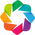

In [7]:
import param
import paramnb

from bokeh.models import WMTSTileSource
from bokeh.tile_providers import STAMEN_TONER
from colorcet import cm
import geoviews as gv
import holoviews as hv
from holoviews.operation.datashader import datashade
from holoviews.streams import RangeXY

hv.notebook_extension('bokeh')

In [74]:
map_providers = {'OpenMap': WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'),
                 'ESRI': WMTSTileSource(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'),
                 'Wikipedia': WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
                 'Stamen Toner': STAMEN_TONER}

tiles = gv.WMTS(map_providers['Stamen Toner'])
tile_options = dict(width=800, height=800, xaxis=None, yaxis=None, bgcolor='black', show_grid=False)

class Options(hv.streams.Stream):
    precipitation_levels = ['= 0 mm', '< 2 mm', '< 10 mm', '< 50 mm', '>= 50 mm']
    Precipitation = param.ObjectSelector(default='= 0 mm', objects=precipitation_levels)
    
    def plot(self, x_range=None, y_range=None, **kwargs):
        map_tiles = tiles(style=dict(alpha=1.0), plot=tile_options)

        filtered_rides = rides[rides['precipitation_quantised'] == self.Precipitation]
        
        pickups = hv.Points(filtered_rides, kdims=['pickup_x', 'pickup_y'], vdims=[])
        dropoffs = hv.Points(filtered_rides, kdims=['dropoff_x', 'dropoff_y'], vdims=[])
        
        pickups_ds = datashade(pickups, width=800, height=800, x_sampling=1, y_sampling=1, cmap=cm['fire'], 
                               element_type=gv.Image, dynamic=False, x_range=x_range, y_range=y_range)
        
        dropoffs_ds = datashade(dropoffs, width=800, height=800, x_sampling=1, y_sampling=1, cmap=cm['fire'], 
                                element_type=gv.Image, dynamic=False, x_range=x_range, y_range=y_range)
                
        return pickups_ds * dropoffs_ds * map_tiles

selector = Options(name='Taxi Rides from Manhattan to JFK International Airport: Please select level of precipitation.')
paramnb.Widgets(selector, callback=selector.update)
hv.DynamicMap(selector.plot, streams=[selector, RangeXY()])

:DynamicMap   []
   :Overlay
      .RGB.I  :RGB   [pickup_x,pickup_y]   (R,G,B,A)
      .RGB.II :RGB   [dropoff_x,dropoff_y]   (R,G,B,A)
      .WMTS.I :WMTS   [Longitude,Latitude]